In [1]:
import numpy as np
from numpy import linalg as LA
import torch; torch.set_default_dtype(torch.float64)
import torch.nn as nn
import torch.optim as optim
import copy
from copy import deepcopy
import matplotlib.pyplot as plt
# import mymodule as myModules
import matplotlib.cm as cm
from scipy import linalg
from timeit import default_timer as timer
import networkx as nx
import os
import pickle
import datetime
#### Import SLOG packakes
from SLOGmodules import SLOGtools as SLOGtools
from SLOGmodules import SLOGobjective as SLOGobj
from SLOGmodules import SLOGarchitectures as SLOGarchi 
from SLOGmodules import SLOGtraining as SLOGtrainer
from SLOGmodules import SLOGmodel as SLOGmodel
from SLOGmodules import SLOGevaluation as SLOGevaluator
from SLOGmodules import SLOGdata as SLOGdata

#### Import GNN packages
from SLOGmodules import graphTools as graphTools
from SLOGmodules import dataTools as dataTools

from alegnn.modules import architectures as archit
from alegnn.modules import model as model
from alegnn.modules import training as training
from alegnn.modules import evaluation as evaluation
from alegnn.modules import loss as loss
from alegnn.utils.miscTools import writeVarValues
from alegnn.utils.miscTools import saveSeed

In [2]:
# from numpy import random
# xy = random.rand(3)
# print(xy)
# print(1 != 2)
# print(xy**2)
# import hdf5storage

In [3]:
### Network parameters
K = 5 # number of layers

### Filter parameters
alpha = 1.0

Parameters

In [4]:
### Simulation parameters
simuParas = {}
nTrain_slog = 100000
batchsize_slog = 400
nValid = batchsize_slog
nTest = batchsize_slog

### Data parameters
L = 5
alpha = 1.0

### Graph parameters

nNodes = 20 # Number of nodes
nClasses = 3 # Number of classes (i.e. number of communities)
N_C = 2 # Number of sources per signal

# nNodes = 100 # Number of nodes
# nClasses = 5 # Number of classes (i.e. number of communities)
# N_C = 10 # Number of sources per signal

simuParas['nNodes'] = nNodes
simuParas['nClasses'] = nClasses
simuParas['N_C'] = N_C

# graphType = 'SBM' # Type of graph
# graphOptions = {} # Dictionary of options to pass to the graphTools.createGraph function
# graphOptions['nCommunities'] = nClasses # Number of communities
# graphOptions['probIntra'] = 0.8 # Probability of drawing edges intra communities
# graphOptions['probInter'] = 0.2 # Probability of drawing edges inter communities

graphType = 'Random Geometric' # Type of graph
graphOptions = {} # Dictionary of options to pass to the graphTools.createGraph function
graphOptions['distance'] = 0.2 # Number of communities

# graphType = 'BA' # Type of graph
# graphOptions = {} # Dictionary of options to pass to the graphTools.createGraph function
# graphOptions['alpha'] = 1.0


### Training parameters
nEpochs = 50

## Filter type: g or h
# filterType = 'g'
filterType = 'h'

## Signal mode: gaussion or 1
signalMode = 'Gaussion'

## Train mode: Wt or default (Vdiag(\tilde{h})V^T)
trainMode = 'default'
# trainMode = 'Wt'

## Filter mode: Wt or default (Vdiag(\tilde{h})V^T)
filterMode = 'default'
# filterMode = 'Wt'

## Selection mode: random or nodes with top-N_C degree
selectMode = 'random'

## Noise level
noiseLevel = 0.1

simuParas['nTrain_slog'] = nTrain_slog
simuParas['batchsize_slog'] = batchsize_slog
simuParas['nValid'] = nValid
simuParas['nTest'] = nTest
simuParas['L'] = L
simuParas['noiseLevel'] = noiseLevel
simuParas['filterType'] = filterType
simuParas['signalMode'] = signalMode
simuParas['trainMode'] = trainMode
simuParas['filterMode'] = filterMode
simuParas['selectMode'] = selectMode


tMax = None # Maximum number of diffusion times (W^t for t < tMax)
tMax = 3


In [10]:

print(nTrain_slog + nValid + nTest)

data = SLOGdata.SLOG_ClassificationData(G, nTrain_slog, nValid, nTest, sourceNodes, communityList, communityLabels, V_slog, eigenvalues_slog, L = L, tMax = tMax, alpha = alpha, filterMode = filterMode, selectMode = selectMode, signalMode = signalMode, filterType = filterType, noiseLevel = noiseLevel)
# data = SLOGdata.SLOGdata(G, nTrain_slog, nValid, nTest, sourceNodes, communityList,communityLabels, V_slog,eigenvalues_slog,alpha = 1.0, selectMode = 'random',signalMode = 'Gaussion')

data.astype(torch.float64)
data.expandDims()

100800
<class 'numpy.float64'>
Number of input nodes per classes: 2 ; number of classes 3
Generating h filter


/Users/changye/github/slog-net/slog-net-master/graph-neural-networks-master/SLOGmodules/SLOGdata.py:472: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  communityNode_set = np.array(communityList)


[ 0.92746509  0.90832209  0.87886603  0.81106942  0.75977442  0.73940985
  0.74869506 -1.48491742  0.84158404  0.89776556  1.49905741  8.88031714
  3.6796233   2.89925298  1.0990142   0.74132389 -9.52448902  2.47624734
  1.20487514  1.0167435 ]
Signal shape: torch.Size([100800, 20])
key: train
key: valid
key: test
key: train
key: valid
key: test


In [11]:
# print(myModel.archit.state_dict())

SLOG-Net Model

In [12]:
C = 1
K = 5
filterTrainType = 'g'
# filterTrainType = 'h'
# tMax = 5
thisLoss = SLOGtools.myLoss
thisEvaluator = SLOGevaluator.evaluate

thisObject = SLOGobj.myFunction_slog_1
SLOG_net = SLOGarchi.GraphSLoG_v1(V_slog,nNodes,C,K, thisObject)

# thisObject = SLOGobj.myFunction_slog_2
# SLOG_net = SLOGarchi.GraphSLoG_v2(V_slog,nNodes,C,K, thisObject)

import torch.optim as optim

model_name = 'SLOG-Net'
optimAlg = 'ADAM'
learningRate = 0.001
beta1 = 0.9
beta2 = 0.999

thisOptim = optim.Adam(SLOG_net.parameters(), lr = learningRate, betas = (beta1,beta2))
thisTrainer = SLOGtrainer.slog_Trainer

myModel = SLOGmodel.Model(SLOG_net,thisLoss,thisOptim, thisTrainer,thisEvaluator,device, model_name,  saveDir, saveDir_dropbox = saveDir_dropbox )

result_train = myModel.train(data,nEpochs, batchsize_slog, validationInterval = 40,trainMode = trainMode,tMax = tMax, filterTrainType = filterTrainType) # model, data, nEpochs, batchSize


Model is saving to dropbox: /Users/changye/Dropbox/onlineResults/experiments/sourceLocSLOGNET-Random Geometric-20220625160101
torch.Size([20, 100000]) torch.Size([2000000])
torch.Size([20, 100000])
torch.Size([20, 400]) torch.Size([8000])
torch.Size([20, 400])
torch.Size([20, 400]) torch.Size([8000])
torch.Size([20, 400]) torch.Size([8000])
400
100000
Generating g filter
[100000, 100000]
torch.Size([2000000])
torch.Size([20, 400])
Number of Batches: 250

Epoch 1

    (E:  1, B:   1) 
	 Loss: 0.0914 [T] 0.0991 [V] 	 RE: 0.9795 [T] 	 RE: 0.9969 [V] 	 Best Loss: 0.0991 [V] 	 Loss: 0.0984 [Test]

    (E:  1, B:  41) 
	 Loss: 0.0932 [T] 0.0987 [V] 	 RE: 0.9996 [T] 	 RE: 0.9952 [V] 	 Best Loss: 0.0987 [V] 	 Loss: 0.0965 [Test]
Best model updated at: 0 40
rho_1 tensor([1.6319, 0.0000, 0.0000, 0.0284, 0.1103])
eta_1 tensor([7.7846e-04, 9.5290e-01, 0.0000e+00, 0.0000e+00, 1.8495e-02])
lmbd tensor([0.0152, 0.4675, 0.0256, 0.0000, 1.4328])
alpha_1 tensor([-0.4250, -0.6371,  0.1785, -0.9987,  0.62


    (E:  3, B: 141) 
	 Loss: 0.0612 [T] 0.0814 [V] 	 RE: 0.7739 [T] 	 RE: 0.9035 [V] 	 Best Loss: 0.0446 [V] 	 Loss: 0.0727 [Test]

    (E:  3, B: 181) 
	 Loss: 0.0973 [T] 0.0960 [V] 	 RE: 0.9903 [T] 	 RE: 0.9813 [V] 	 Best Loss: 0.0446 [V] 	 Loss: 0.0749 [Test]

    (E:  3, B: 221) 
	 Loss: 0.0524 [T] 0.0615 [V] 	 RE: 0.7088 [T] 	 RE: 0.7858 [V] 	 Best Loss: 0.0446 [V] 	 Loss: 0.0819 [Test]
Mean training time =  0.012604362216000026

Epoch 4

    (E:  4, B:  11) 
	 Loss: 0.0723 [T] 0.1036 [V] 	 RE: 0.8763 [T] 	 RE: 1.0196 [V] 	 Best Loss: 0.0446 [V] 	 Loss: 0.0745 [Test]

    (E:  4, B:  51) 
	 Loss: 0.0956 [T] 0.0684 [V] 	 RE: 0.9617 [T] 	 RE: 0.8283 [V] 	 Best Loss: 0.0446 [V] 	 Loss: 0.0824 [Test]

    (E:  4, B:  91) 
	 Loss: 0.0798 [T] 0.0847 [V] 	 RE: 0.8915 [T] 	 RE: 0.9217 [V] 	 Best Loss: 0.0446 [V] 	 Loss: 0.0729 [Test]

    (E:  4, B: 131) 
	 Loss: 0.0705 [T] 0.0601 [V] 	 RE: 0.8096 [T] 	 RE: 0.7764 [V] 	 Best Loss: 0.0446 [V] 	 Loss: 0.0881 [Test]

    (E:  4, B: 171) 
	 


    (E: 10, B: 111) 
	 Loss: 0.0471 [T] 0.0427 [V] 	 RE: 0.6652 [T] 	 RE: 0.6545 [V] 	 Best Loss: 0.0296 [V] 	 Loss: 0.0696 [Test]

    (E: 10, B: 151) 
	 Loss: 0.0299 [T] 0.0327 [V] 	 RE: 0.5683 [T] 	 RE: 0.5724 [V] 	 Best Loss: 0.0296 [V] 	 Loss: 0.0668 [Test]

    (E: 10, B: 191) 
	 Loss: 0.0503 [T] 0.0481 [V] 	 RE: 0.7057 [T] 	 RE: 0.6944 [V] 	 Best Loss: 0.0296 [V] 	 Loss: 0.0670 [Test]

    (E: 10, B: 231) 
	 Loss: 0.0545 [T] 0.0566 [V] 	 RE: 0.7400 [T] 	 RE: 0.7538 [V] 	 Best Loss: 0.0296 [V] 	 Loss: 0.0684 [Test]
Mean training time =  0.011879347472001655

Epoch 11

    (E: 11, B:  21) 
	 Loss: 0.0311 [T] 0.0356 [V] 	 RE: 0.5684 [T] 	 RE: 0.5974 [V] 	 Best Loss: 0.0296 [V] 	 Loss: 0.0659 [Test]

    (E: 11, B:  61) 
	 Loss: 0.0243 [T] 0.0274 [V] 	 RE: 0.5012 [T] 	 RE: 0.5243 [V] 	 Best Loss: 0.0274 [V] 	 Loss: 0.0669 [Test]
Best model updated at: 10 60
rho_1 tensor([1.6319, 0.0926, 0.0958, 0.5413, 0.5968])
eta_1 tensor([0.2567, 1.8178, 0.0089, 0.0035, 0.5157])
lmbd tensor([0.0

Mean training time =  0.011812245875997178

Epoch 18

    (E: 18, B:  31) 
	 Loss: 0.0357 [T] 0.0253 [V] 	 RE: 0.5844 [T] 	 RE: 0.5033 [V] 	 Best Loss: 0.0219 [V] 	 Loss: 0.0654 [Test]

    (E: 18, B:  71) 
	 Loss: 0.0259 [T] 0.0234 [V] 	 RE: 0.5162 [T] 	 RE: 0.4847 [V] 	 Best Loss: 0.0219 [V] 	 Loss: 0.0652 [Test]

    (E: 18, B: 111) 
	 Loss: 0.0311 [T] 0.0316 [V] 	 RE: 0.5541 [T] 	 RE: 0.5630 [V] 	 Best Loss: 0.0219 [V] 	 Loss: 0.0660 [Test]

    (E: 18, B: 151) 
	 Loss: 0.0245 [T] 0.0284 [V] 	 RE: 0.5174 [T] 	 RE: 0.5336 [V] 	 Best Loss: 0.0219 [V] 	 Loss: 0.0648 [Test]

    (E: 18, B: 191) 
	 Loss: 0.0423 [T] 0.0456 [V] 	 RE: 0.6607 [T] 	 RE: 0.6763 [V] 	 Best Loss: 0.0219 [V] 	 Loss: 0.0648 [Test]

    (E: 18, B: 231) 
	 Loss: 0.0565 [T] 0.0552 [V] 	 RE: 0.7519 [T] 	 RE: 0.7444 [V] 	 Best Loss: 0.0219 [V] 	 Loss: 0.0657 [Test]
Mean training time =  0.011949357819997659

Epoch 19

    (E: 19, B:  21) 
	 Loss: 0.0328 [T] 0.0299 [V] 	 RE: 0.5433 [T] 	 RE: 0.5477 [V] 	 Best Loss: 0.0


    (E: 25, B:  41) 
	 Loss: 0.0393 [T] 0.0404 [V] 	 RE: 0.6434 [T] 	 RE: 0.6369 [V] 	 Best Loss: 0.0122 [V] 	 Loss: 0.0600 [Test]

    (E: 25, B:  81) 
	 Loss: 0.0575 [T] 0.0563 [V] 	 RE: 0.7484 [T] 	 RE: 0.7514 [V] 	 Best Loss: 0.0122 [V] 	 Loss: 0.0601 [Test]

    (E: 25, B: 121) 
	 Loss: 0.0479 [T] 0.0528 [V] 	 RE: 0.7039 [T] 	 RE: 0.7279 [V] 	 Best Loss: 0.0122 [V] 	 Loss: 0.0595 [Test]

    (E: 25, B: 161) 
	 Loss: 0.0484 [T] 0.0449 [V] 	 RE: 0.7001 [T] 	 RE: 0.6710 [V] 	 Best Loss: 0.0122 [V] 	 Loss: 0.0581 [Test]

    (E: 25, B: 201) 
	 Loss: 0.0677 [T] 0.0743 [V] 	 RE: 0.8370 [T] 	 RE: 0.8631 [V] 	 Best Loss: 0.0122 [V] 	 Loss: 0.0572 [Test]

    (E: 25, B: 241) 
	 Loss: 0.0113 [T] 0.0125 [V] 	 RE: 0.3252 [T] 	 RE: 0.3546 [V] 	 Best Loss: 0.0122 [V] 	 Loss: 0.0572 [Test]
Mean training time =  0.011571888888000103

Epoch 26

    (E: 26, B:  31) 
	 Loss: 0.0145 [T] 0.0138 [V] 	 RE: 0.3812 [T] 	 RE: 0.3727 [V] 	 Best Loss: 0.0122 [V] 	 Loss: 0.0566 [Test]

    (E: 26, B:  71) 
	


    (E: 32, B:  51) 
	 Loss: 0.0313 [T] 0.0309 [V] 	 RE: 0.5472 [T] 	 RE: 0.5569 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0574 [Test]

    (E: 32, B:  91) 
	 Loss: 0.0472 [T] 0.0421 [V] 	 RE: 0.6768 [T] 	 RE: 0.6497 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0570 [Test]

    (E: 32, B: 131) 
	 Loss: 0.0291 [T] 0.0293 [V] 	 RE: 0.5243 [T] 	 RE: 0.5424 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0578 [Test]

    (E: 32, B: 171) 
	 Loss: 0.0286 [T] 0.0324 [V] 	 RE: 0.5420 [T] 	 RE: 0.5704 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0609 [Test]

    (E: 32, B: 211) 
	 Loss: 0.0447 [T] 0.0458 [V] 	 RE: 0.6721 [T] 	 RE: 0.6781 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0557 [Test]
Mean training time =  0.011821403836011086

Epoch 33

    (E: 33, B:   1) 
	 Loss: 0.0239 [T] 0.0299 [V] 	 RE: 0.4827 [T] 	 RE: 0.5474 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0550 [Test]

    (E: 33, B:  41) 
	 Loss: 0.0378 [T] 0.0380 [V] 	 RE: 0.6427 [T] 	 RE: 0.6177 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0548 [Test]

    (E: 33, B:  81) 
	


    (E: 41, B: 161) 
	 Loss: 0.0440 [T] 0.0430 [V] 	 RE: 0.6926 [T] 	 RE: 0.6566 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0549 [Test]

    (E: 41, B: 201) 
	 Loss: 0.0743 [T] 0.0770 [V] 	 RE: 0.8320 [T] 	 RE: 0.8790 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0539 [Test]

    (E: 41, B: 241) 
	 Loss: 0.0134 [T] 0.0094 [V] 	 RE: 0.3682 [T] 	 RE: 0.3072 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0543 [Test]
Mean training time =  0.011977748660000544

Epoch 42

    (E: 42, B:  31) 
	 Loss: 0.0127 [T] 0.0143 [V] 	 RE: 0.3499 [T] 	 RE: 0.3793 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0544 [Test]

    (E: 42, B:  71) 
	 Loss: 0.0076 [T] 0.0106 [V] 	 RE: 0.2745 [T] 	 RE: 0.3258 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0553 [Test]

    (E: 42, B: 111) 
	 Loss: 0.0221 [T] 0.0171 [V] 	 RE: 0.4702 [T] 	 RE: 0.4140 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0550 [Test]

    (E: 42, B: 151) 
	 Loss: 0.0172 [T] 0.0204 [V] 	 RE: 0.4251 [T] 	 RE: 0.4523 [V] 	 Best Loss: 0.0084 [V] 	 Loss: 0.0569 [Test]

    (E: 42, B: 191) 
	


    (E: 50, B:  71) 
	 Loss: 0.0158 [T] 0.0118 [V] 	 RE: 0.3856 [T] 	 RE: 0.3448 [V] 	 Best Loss: 0.0075 [V] 	 Loss: 0.0559 [Test]

    (E: 50, B: 111) 
	 Loss: 0.0223 [T] 0.0177 [V] 	 RE: 0.4629 [T] 	 RE: 0.4219 [V] 	 Best Loss: 0.0075 [V] 	 Loss: 0.0560 [Test]

    (E: 50, B: 151) 
	 Loss: 0.0199 [T] 0.0207 [V] 	 RE: 0.4296 [T] 	 RE: 0.4554 [V] 	 Best Loss: 0.0075 [V] 	 Loss: 0.0531 [Test]

    (E: 50, B: 191) 
	 Loss: 0.0330 [T] 0.0321 [V] 	 RE: 0.5809 [T] 	 RE: 0.5673 [V] 	 Best Loss: 0.0075 [V] 	 Loss: 0.0539 [Test]

    (E: 50, B: 231) 
	 Loss: 0.0442 [T] 0.0436 [V] 	 RE: 0.6682 [T] 	 RE: 0.6617 [V] 	 Best Loss: 0.0075 [V] 	 Loss: 0.0527 [Test]
Mean training time =  0.011712778895992414



In [13]:
top_N = N_C
# top_N = 1
result_evaluate_slog = myModel.evaluate(data, topN = top_N)
print(result_evaluate_slog)
print(data.samples['test']['sampleTimes'])
slog_error_n_c = result_evaluate_slog

top_N = 1
result_evaluate_slog = myModel.evaluate(data, topN = top_N)
print(result_evaluate_slog)
print(data.samples['test']['sampleTimes'])
slog_error_1 = result_evaluate_slog

Sample shape Y: torch.Size([20, 400]) , X: torch.Size([20, 400]) , targets: torch.Size([400])
{'costBest': 0.615, 'costLast': 0.5875}
{'costBest': 0.615, 'costLast': 0.5875}
[1]
Sample shape Y: torch.Size([20, 400]) , X: torch.Size([20, 400]) , targets: torch.Size([400])
{'costBest': 0.61, 'costLast': 0.59}
{'costBest': 0.61, 'costLast': 0.59}
[1]


In [14]:
# gT = data.samples['test']['gT']
# print(gT)
# print(g_test)
for n,p in  myModel.trainer.bestModel.named_parameters():
    if p.requires_grad:
        print(n, p.data)
        

rho_1 tensor([1.6319, 0.1336, 0.1316, 0.8058, 1.0267])
eta_1 tensor([0.4188, 2.0382, 0.0901, 0.0090, 0.0056])
lmbd tensor([0.1812, 0.4900, 0.1781, 0.3490, 1.4328])
alpha_1 tensor([-0.2990, -0.6129,  0.8362, -1.9550,  0.6211])
alpha_2 tensor([ 0.6153,  0.7930, -1.2052,  2.0759, -0.3904])
beta_1 tensor([ 0.1329, -1.6317, -1.9411, -2.3164, -0.0256])
beta_2 tensor([ 0.0051, -1.1055, -1.7375,  0.3226, -0.8952])
beta_3 tensor([-0.1949, -1.1948, -1.4564, -2.6311, -0.3953])
gamma_1 tensor([-1.5596, -3.0533, -1.3588,  0.6744, -0.1629])
gamma_2 tensor([ 0.6771,  0.6925, -0.5808, -0.8898,  0.7492])
gamma_3 tensor([ 2.1789, -1.9543,  1.5341,  0.9637, -0.3186])


Re-generate sample shape Y: torch.Size([400, 20])
Sample shape Y: torch.Size([20, 400]) , X: torch.Size([20, 400]) , targets: torch.Size([400])
Sample shape Y: torch.Size([20, 400]) , X: torch.Size([20, 400]) , targets: torch.Size([400])
{'costBest': 0.65, 'costLast': 0.65}
{'costBest': 0.65, 'costLast': 0.65}
torch.Size([20, 400])


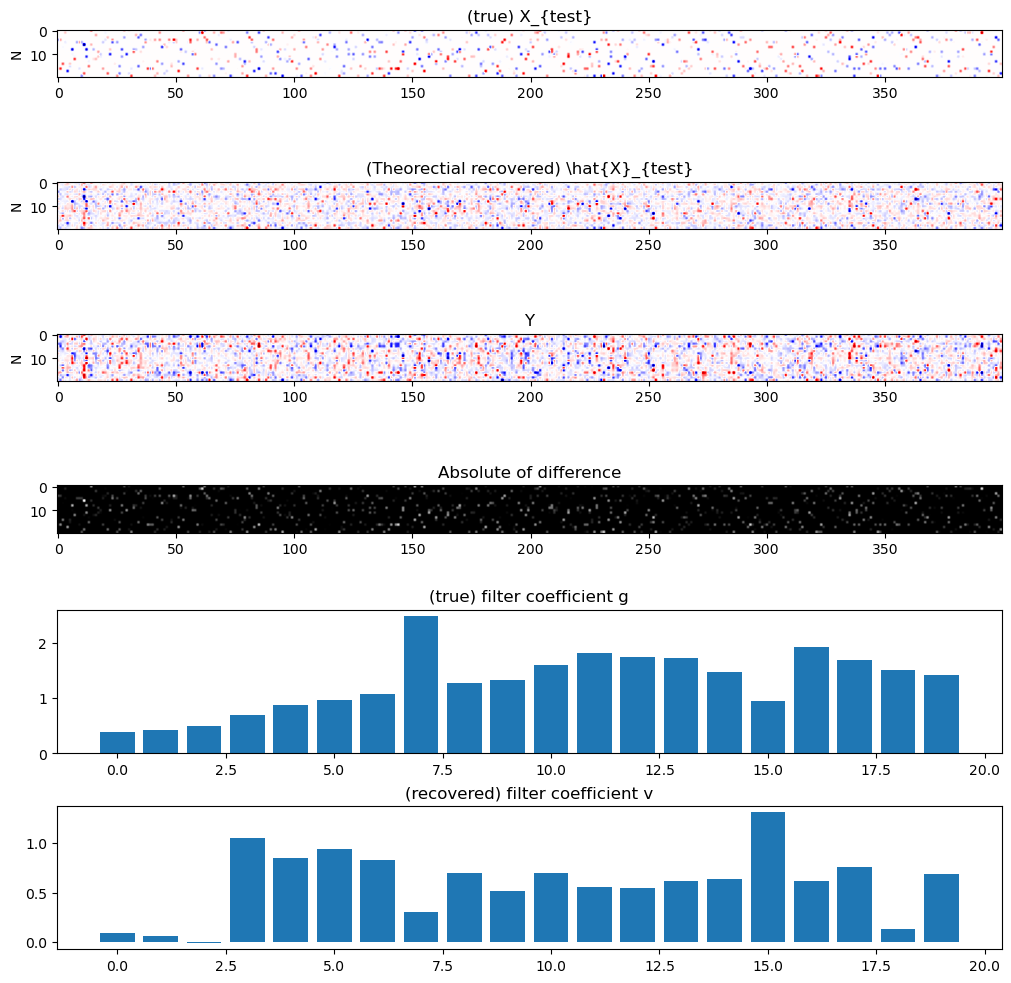

In [15]:
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# P_test = 400
alpha = 1.0
L = 10
# theta = 0.2
N = nNodes
# L = 5
# n_batch = batch-1
# g_test = np.ones(N)+alpha*np.random.normal(0, 1, N) 
# g_test = g_test/np.sum(g_test)

g_test = SLOGtools.h_generate_gso(N,alpha, eigenvalues_slog,L)

Y_test = data.generate_new_test_Samples(g_test)

Y_test,X_test,targets,g_test = data.get_test_Samples()
# Y_test,X_test,targets = data.get_valid_Samples(g_test)

N = nNodes
P_test = nTest
# bestModel_slog = result_train
bestModel_slog = myModel.trainer.bestModel
# g_test = myModules.g_generate_gso(N,alpha, eigenvalues_slog,L)

# Choose V
# V1 = generate_V(N)
V1 = V_slog

result_evaluate = myModel.evaluate(data, topN = 5)
print(result_evaluate)
# YTest = (data.samples)['test']['signals']
# YTest = torch.reshape(torch.transpose(YTest, 0, 2),(nNodes,nTest_slog))
# yTest = torch.reshape(YTrain, (nNodes*nTest_slog,))
# X_test = (data.samples)['test']['X0']
# X_test = X_test.numpy()
# xTest = torch.reshape(XTest, (nNodes*nTest_slog,))
# yTest = Y[:,nTest_slog:]
# nTest = xTest.shape[1]

# g_test = np.ones(N)+alpha*np.random.normal(0, 1, N)
# h_test = 1./g_test
# H_test = np.dot(V1,np.dot(np.diag(h_test),np.transpose(V1)))
# Y_test = torch.tensor(np.dot(H_test,X_test))

# X_test,Y_test = myModules.Xdata_generate(N,P_test,V1,g_test, theta,alpha)
# Y_test = torch.tensor(Y_test)

# Choose X


# X_test = X_test.reshape(N,P_test)
# print(X_test)
print(X_test.shape)

# H = np.dot(V1,np.dot(np.diag(h_test),np.transpose(V1)))
# Y_test = torch.tensor(np.dot(H,X_test))
# Y_test = yTrainBatch

x_test_Predict, v_test_Predict = bestModel_slog(Y_test)
# x_test_Predict, v_test_Predict = graphFilter(Y_test)

g_pre = v_test_Predict.detach().numpy()
# print(np.transpose(g_test))
# print(g_pre)

G_test = np.dot(V1,np.dot(np.diag(g_pre),np.transpose(V1)))
X_theory = torch.tensor(np.dot(G_test,Y_test)).detach().numpy()

X_test_Predict = x_test_Predict.detach().numpy()
X_test_Predict = X_test_Predict.reshape(N,P_test)

X_test = X_test.numpy()
max_X = np.max(np.abs(X_test))
max_X_theory = np.max(np.abs(X_theory))
max_Y = np.max(np.abs(Y_test.detach().numpy()))
max_XP = np.max(np.abs(X_test_Predict))
fig, axes = plt.subplots(nrows=6, ncols=1, constrained_layout=True,figsize=(10,10))
axes[0].imshow(X_test,  cmap=cm.seismic,vmin = -max_X, vmax = max_X)
axes[0].set_title('(true) X_{test}')
axes[0].set_ylabel('N')
axes[2].imshow(Y_test, cmap=cm.seismic,vmin = -max_Y, vmax = max_Y)
axes[2].set_title('Y')
axes[2].set_ylabel('N')
axes[1].imshow(X_theory, cmap=cm.seismic,vmin = -max_X_theory, vmax = max_X_theory)
axes[1].set_title('(Theorectial recovered) \hat{X}_{test}')
axes[1].set_ylabel('N')
axes[3].imshow(np.abs(X_test_Predict - X_test),  cmap=cm.Greys_r)
axes[3].set_title('Absolute of difference')
axes[4].bar(np.array(range(N)),g_test)
axes[4].set_title('(true) filter coefficient g')
axes[5].bar(np.array(range(N)),g_pre)
axes[5].set_title('(recovered) filter coefficient v')
plt.show()


In [16]:
print(V1)

[[ 1.82574186e-01  8.77040173e-02  1.60574783e-01  2.92560609e-01
   3.31560644e-01 -3.66081801e-01 -3.40453626e-02 -1.07355461e-01
  -3.98231250e-02  3.97558138e-01  4.69081507e-01 -4.45354271e-02
  -4.27071031e-01  1.50392388e-01  6.55691922e-02  1.50701215e-16
  -7.18984208e-18 -8.31901948e-16 -1.82811914e-16 -1.59880962e-17]
 [ 2.23606798e-01  3.53876978e-01 -2.20594146e-01 -7.18282344e-02
   3.34723439e-02  2.90785459e-01  1.90373594e-02  3.02120396e-01
  -1.32657828e-01  2.70827834e-01  3.35449813e-02  6.53122754e-04
   3.74278809e-02 -3.14357713e-03  1.23304831e-02 -8.19631132e-17
   9.59236280e-17 -2.89309688e-16  7.07106781e-01 -3.56742536e-16]
 [ 2.58198890e-01 -2.72566421e-01 -1.73015890e-01 -1.64206811e-02
   6.44462078e-03  1.71923013e-02 -5.16877737e-01  3.05076525e-03
   1.74777664e-01  1.41205875e-01 -1.19473775e-01 -4.03925532e-01
  -9.82018537e-03  1.19404590e-01 -5.64851919e-01  1.11901788e-17
   3.67371011e-16 -2.32483870e-16 -5.12843002e-16  1.93771943e-16]
 [ 1.82